# Validation of effective Hamiltonian extraction

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import h5py
import rqutils.paulis as paulis
from rqutils.qprint import qprint
from rqutils.math import matrix_exp, matrix_angle
import qudit_sim
from qudit_sim import FrequencyScale

try:
    os.makedirs('heff_validation')
except OSError:
    pass

## Single qubit resonant drive

In [2]:
hgen = qudit_sim.HamiltonianGenerator(2)
hgen.add_qudit(qubit_frequency=100., anharmonicity=-8., drive_amplitude=6., qudit_id='q0')
hgen.add_drive('q0', frequency=100., amplitude=0.1)

In [3]:
qudit_sim.print_hamiltonian(hgen.generate(rwa=True))

LaTeXRepr("\begin{align}H_{\mathrm{static}} & = 0.300| 0 \rangle\langle 1 | + 0.300| 1 \rangle\langle 0 |\end{align}")

In [4]:
sim_result = qudit_sim.pulse_sim(hgen, tlist=(10, 10))
components = qudit_sim.find_heff(sim_result, save_result_to='heff_validation/single_qubit_resonant')
qprint(components, 'pauli')

LaTeXRepr("\begin{split} 0.300X \end{split}")

In [5]:
qudit_sim.heff.print_components(components, scale=FrequencyScale.Hz)

LaTeXRepr("\begin{split} \frac{H_{\mathrm{eff}}}{\mathrm{Hz}} = 0.048X \end{split}")

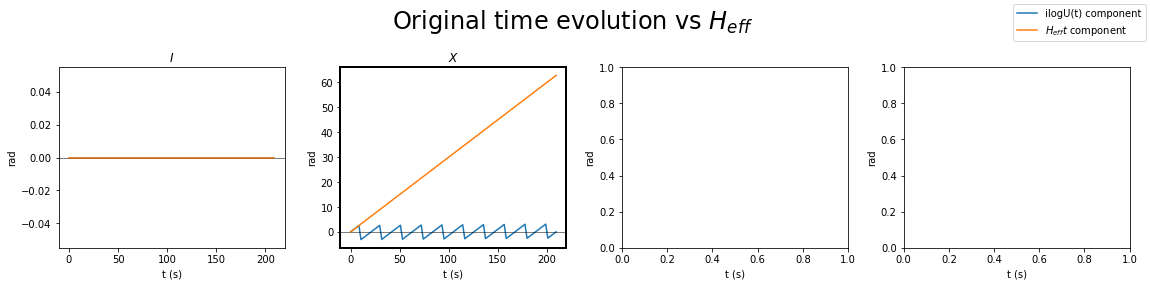

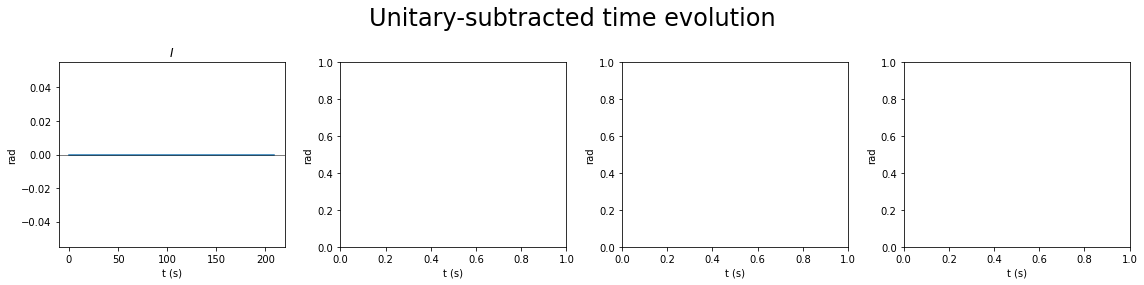

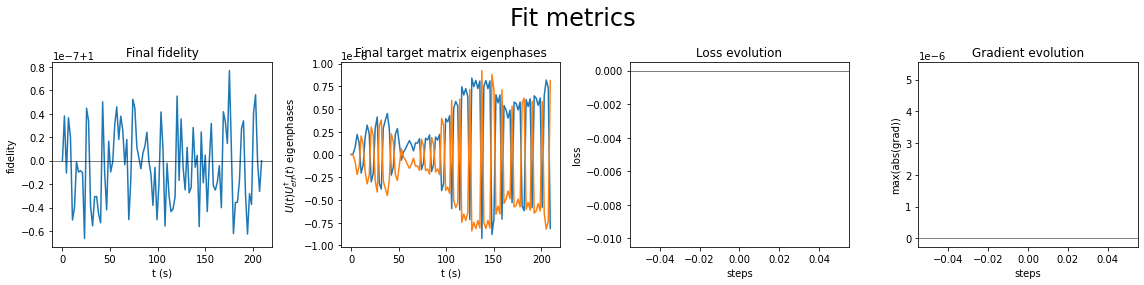

In [6]:
qudit_sim.heff.inspect_fidelity_maximization('heff_validation/single_qubit_resonant.h5', tscale=FrequencyScale.Hz);

## Single qubit off-resonant drive

In [7]:
hgen = qudit_sim.HamiltonianGenerator(2)
hgen.add_qudit(qubit_frequency=100., anharmonicity=-8., drive_amplitude=6., qudit_id='q0')
hgen.add_drive('q0', frequency=101., amplitude=0.1)
sim_result = qudit_sim.pulse_sim(hgen, tlist=(10, 100))
components = qudit_sim.find_heff(sim_result, save_result_to='heff_validation/single_qubit_offresonant')
qprint(components, 'pauli')

LaTeXRepr("\begin{split} 0.023X - 0.000Y + 0.080Z \end{split}")

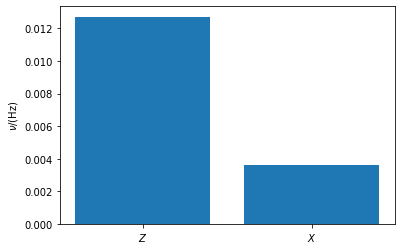

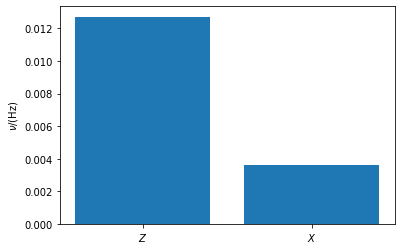

In [8]:
qudit_sim.heff.plot_components(components, threshold=0.001, scale=FrequencyScale.Hz)

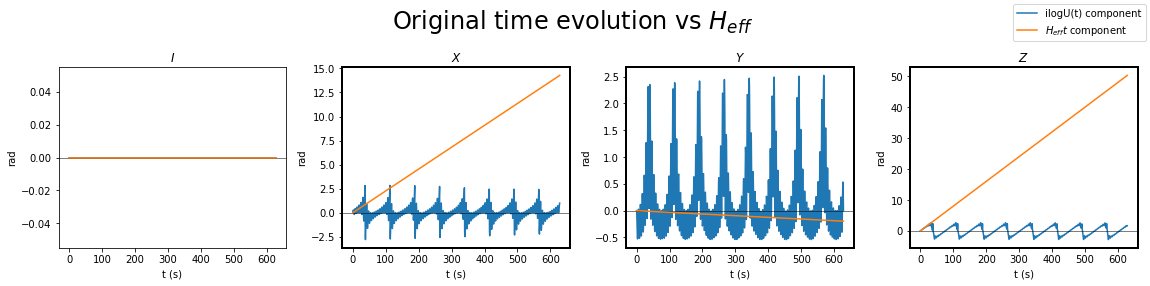

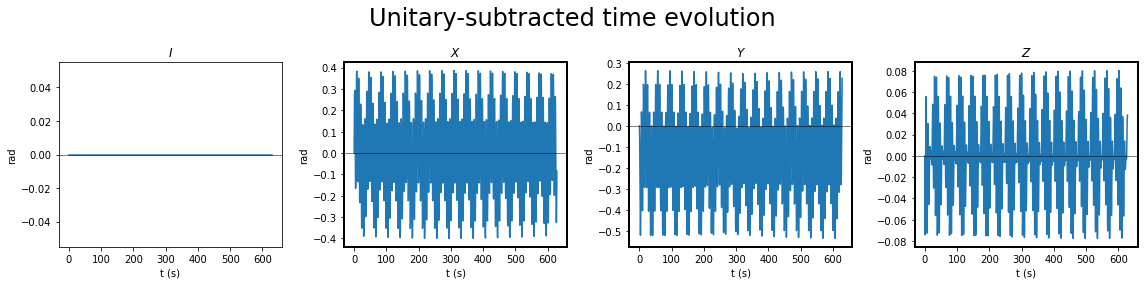

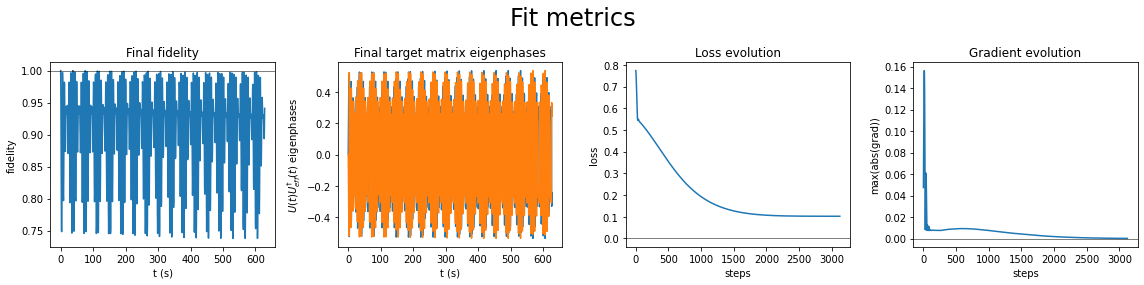

In [9]:
qudit_sim.heff.inspect_fidelity_maximization('heff_validation/single_qubit_offresonant.h5', tscale=FrequencyScale.Hz);

As in the validation of simulation, the drive-frame Hamiltonian is

In [10]:
hgen.set_frame('q0', frequency=np.full(1, 101.))
qudit_sim.print_hamiltonian(hgen.generate())

LaTeXRepr("\begin{align}H_{\mathrm{static}} & = 0.300| 0 \rangle\langle 1 | + 0.300| 1 \rangle\langle 0 | - | 1 \rangle\langle 1 |\end{align}")

The qudit-frame time evolution is given by

$$
\begin{split}
T\left[\exp\left(-i \int_{t_0}^{t_1} dt H_{\mathrm{q.f.}}(t)\right) \right] & = U_q(t_1) U_d(t_1)^{\dagger} e^{-i H_{\mathrm{d.f.}}(t_1 - t_0)} U_d(t_0) U_q(t_0)^{\dagger} \\
& = \exp \left(-i \frac{\omega_q - \omega_d}{2} \sigma_z t_1 \right) e^{-i H_{\mathrm{d.f.}}(t_1 - t_0)} \exp \left(i \frac{\omega_q - \omega_d}{2} \sigma_z t_0 \right).
\end{split}
$$

Validate that a correct time evolution operator was passed to find_heff (this is rather a validation of the simulation part):

In [11]:
tlist = sim_result.times
hdf = hgen.generate()[0].full()
udf = matrix_exp(-1.j * tlist[:, None, None] * hdf[None, ...], hermitian=-1)
sigmaz = paulis.paulis(2)[3]
uq_uddag = matrix_exp(-1.j * (100. - 101.) * 0.5 * tlist[:, None, None] * sigmaz[None, ...], hermitian=-1)
time_evolution = uq_uddag @ udf

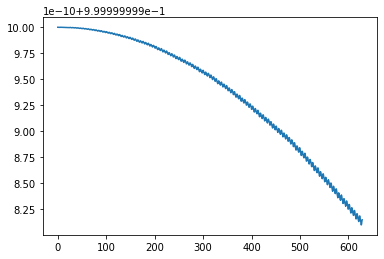

In [12]:
with h5py.File('heff_validation/single_qubit_offresonant.h5') as source:
    sim_time_evolution = source['time_evolution'][()]
    
plt.plot(tlist, np.abs(np.trace(time_evolution.transpose((0, 2, 1)).conjugate() @ sim_time_evolution, axis1=1, axis2=2)) / 2);

## Single qutrit qubit-resonant drive, qubit $H_{\mathrm{eff}}$ extraction

In [13]:
hgen = qudit_sim.HamiltonianGenerator(3)
hgen.add_qudit(qubit_frequency=100., anharmonicity=-8., drive_amplitude=6., qudit_id='q0')
hgen.add_drive('q0', frequency=100., amplitude=0.1)

In [14]:
qudit_sim.print_hamiltonian(hgen.generate(rwa=True))

LaTeXRepr("\begin{align}H_{\mathrm{static}} & = 0.300| 0 \rangle\langle 1 | + 0.300| 1 \rangle\langle 0 | \\ H_{0} & = [\text{(0.30000000000000004 * cos(8.0 * t))}]*  \left( 1.414| 1 \rangle\langle 2 | + 1.414| 2 \rangle\langle 1 | \right) \\ H_{1} & = [\text{(-0.30000000000000004 * sin(8.0 * t))}]*  \left( -1.414i| 1 \rangle\langle 2 | + 1.414i| 2 \rangle\langle 1 | \right)\end{align}")

In [15]:
sim_result = qudit_sim.pulse_sim(hgen, tlist=(10, 100))
components = qudit_sim.find_heff(sim_result, save_result_to='heff_validation/single_qutrit_resonant')
qprint(components, 'pauli')

LaTeXRepr("\begin{split} 0.011I + 0.299X - 0.000Y - 0.011Z \end{split}")

In [16]:
qudit_sim.heff.print_components(components, scale=FrequencyScale.Hz)

LaTeXRepr("\begin{split} \frac{H_{\mathrm{eff}}}{\mathrm{Hz}} = 0.048X \end{split}")

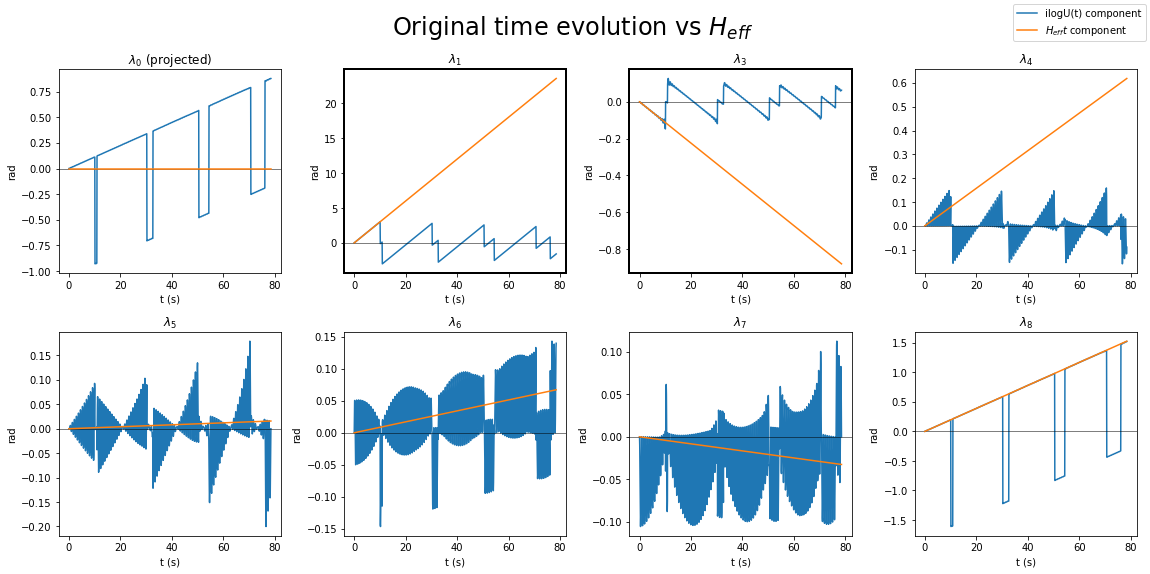

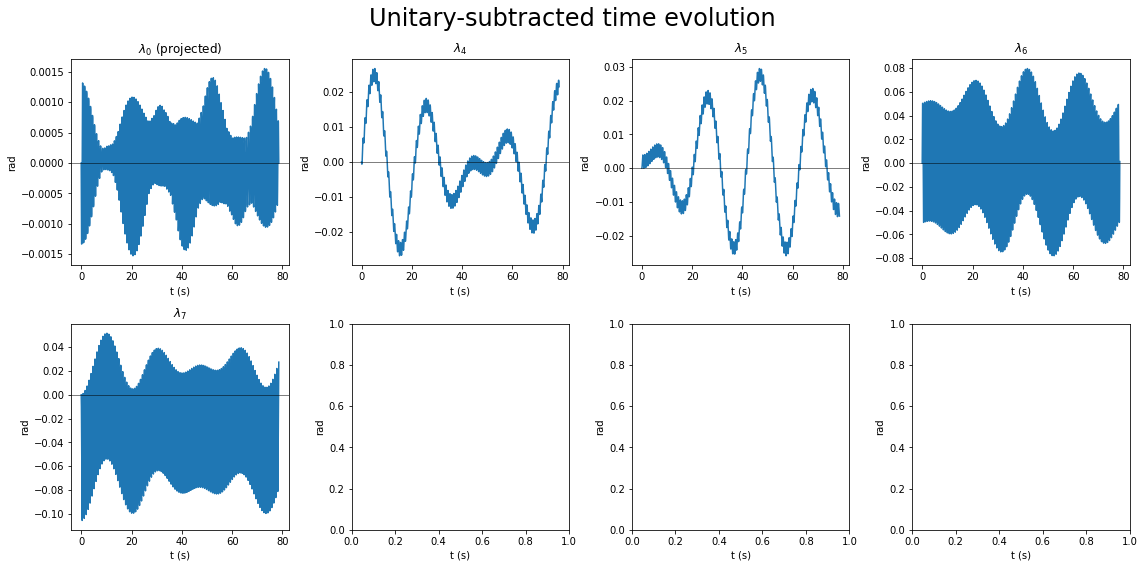

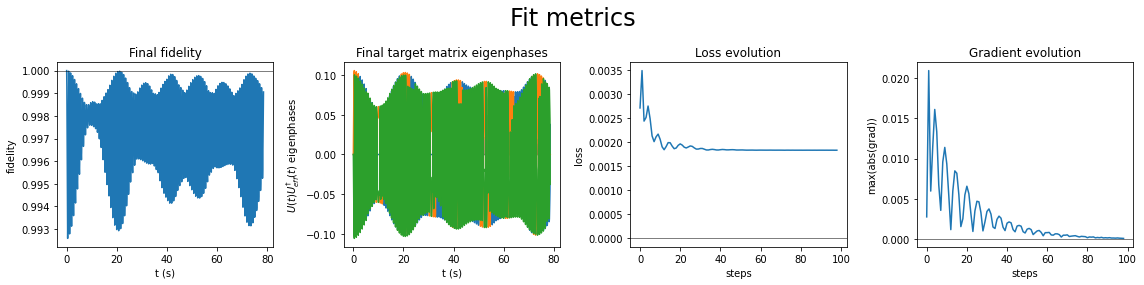

In [17]:
qudit_sim.heff.inspect_fidelity_maximization('heff_validation/single_qutrit_resonant.h5', tscale=FrequencyScale.Hz);

## Two qubit cross resonance, no crosstalk

In [18]:
hgen = qudit_sim.HamiltonianGenerator(2)
hgen.add_qudit(qubit_frequency=100000., anharmonicity=-8000., drive_amplitude=6000., qudit_id='q0')
hgen.add_qudit(qubit_frequency=110000., anharmonicity=-7000., drive_amplitude=7000., qudit_id='q1')
hgen.add_coupling('q0', 'q1', 30.)
hgen.add_drive('q0', frequency=110000., amplitude=0.2)

In [19]:
qudit_sim.print_hamiltonian(hgen.generate(rwa=True), has_static=False)

LaTeXRepr("\begin{align}H_{0} & = [\text{cos(-10000.0*t)}]*  \left( 30| 0,1 \rangle\langle 1,0 | + 30| 1,0 \rangle\langle 0,1 | \right) \\ H_{1} & = [\text{sin(-10000.0*t)}]*  \left( -30i| 0,1 \rangle\langle 1,0 | + 30i| 1,0 \rangle\langle 0,1 | \right) \\ H_{2} & = [\text{(600.0 * cos(10000.0 * t))}]*  \left( | 0,0 \rangle\langle 1,0 | + | 0,1 \rangle\langle 1,1 | + | 1,0 \rangle\langle 0,0 | + | 1,1 \rangle\langle 0,1 | \right) \\ H_{3} & = [\text{(-600.0 * sin(10000.0 * t))}]*  \left( -i| 0,0 \rangle\langle 1,0 | - i| 0,1 \rangle\langle 1,1 | + i| 1,0 \rangle\langle 0,0 | + i| 1,1 \rangle\langle 0,1 | \right)\end{align}")

In [20]:
sim_result = qudit_sim.pulse_sim(hgen, tlist=(10, 100))
components = qudit_sim.find_heff(sim_result, save_result_to='heff_validation/cross_resonance')
qprint(components, 'pauli')

LaTeXRepr("\begin{split} -0.001\frac{IY}{2} - 0.089\frac{IZ}{2} + 2.300\frac{XI}{2} + 0.203\frac{XX}{2} - 0.038\frac{XY}{2} - 0.007\frac{XZ}{2} + 0.614\frac{YI}{2} + 0.019\frac{YX}{2} + 0.051\frac{YY}{2} - 0.012\frac{YZ}{2} + 71.767\frac{ZI}{2} + 3.566\frac{ZX}{2} + 0.002\frac{ZY}{2} + 0.001\frac{ZZ}{2} \end{split}")

In [21]:
qudit_sim.heff.print_components(components, scale=FrequencyScale.Hz)

LaTeXRepr("\begin{split} \frac{H_{\mathrm{eff}}}{\mathrm{Hz}} = -0.014\frac{IZ}{2} + 0.366\frac{XI}{2} + 0.032\frac{XX}{2} + 0.098\frac{YI}{2} + 11.422\frac{ZI}{2} + 0.568\frac{ZX}{2} \end{split}")

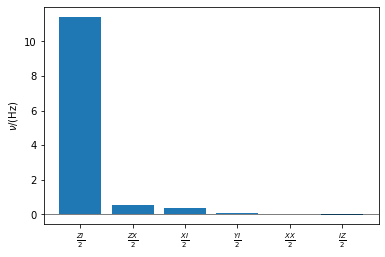

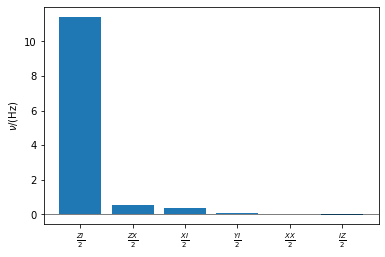

In [22]:
qudit_sim.heff.plot_components(components, scale=FrequencyScale.Hz)

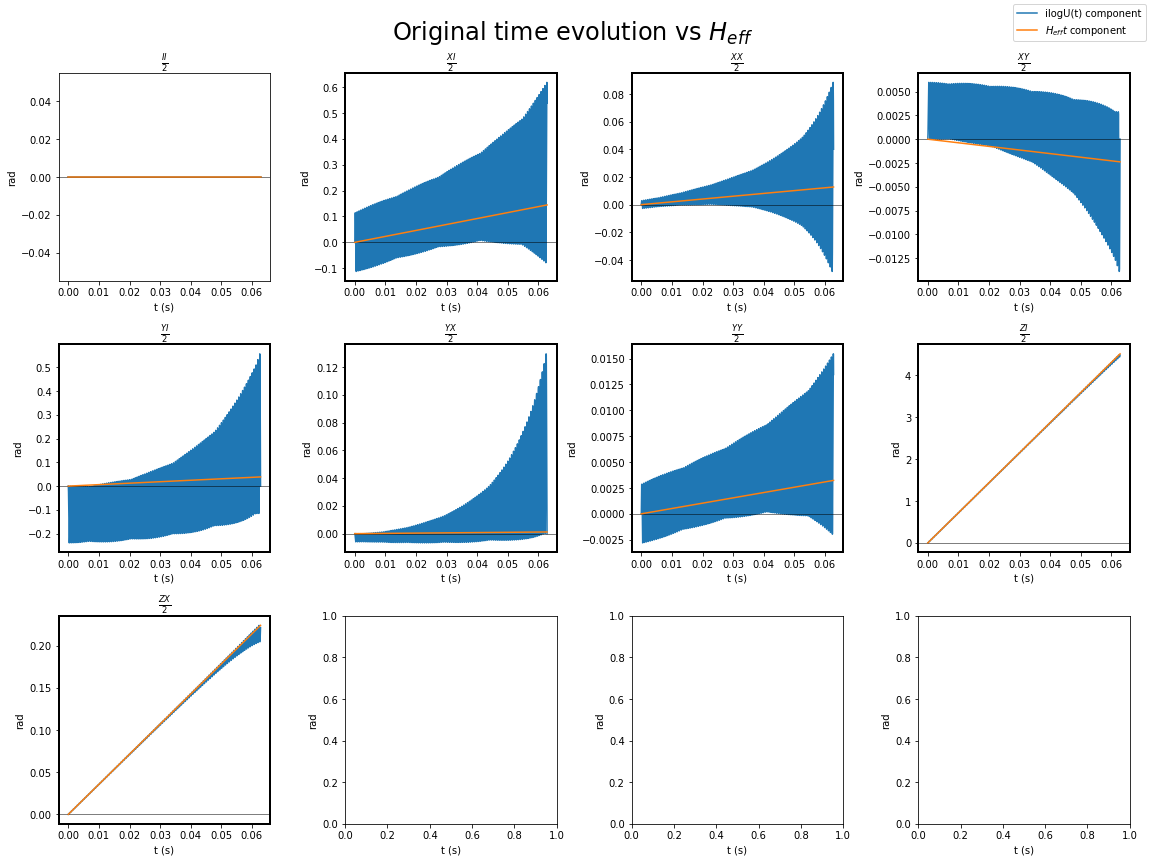

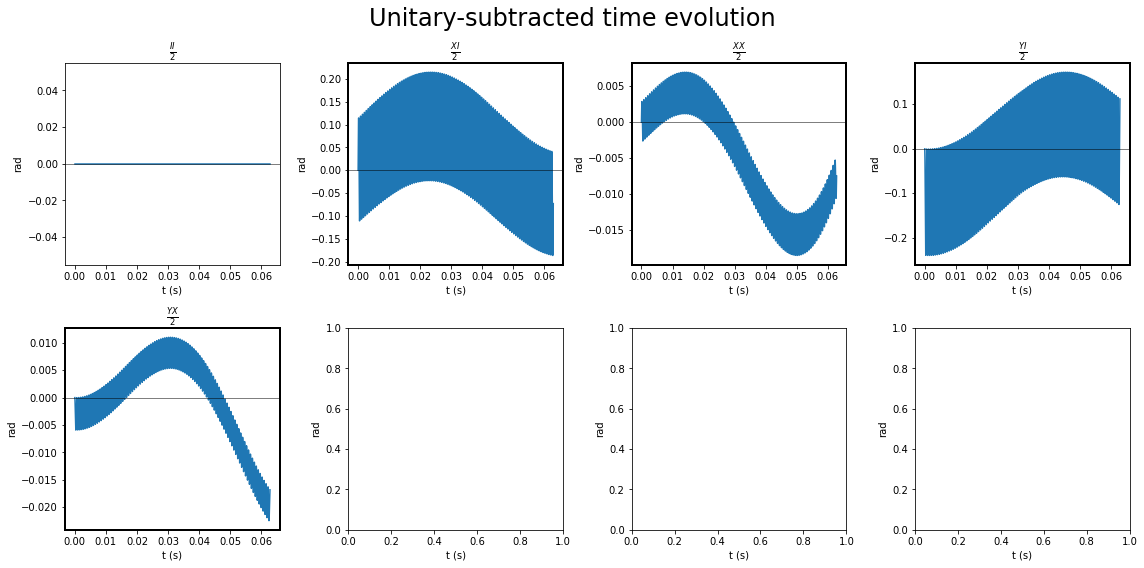

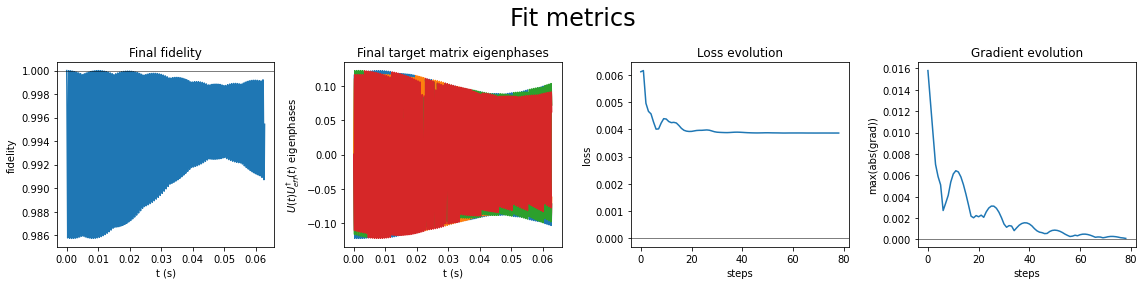

In [23]:
qudit_sim.heff.inspect_fidelity_maximization('heff_validation/cross_resonance.h5', tscale=FrequencyScale.Hz);

## Cross resonance amplitude scan

In [24]:
amplitudes = np.linspace(-0.5, 0.5, 20)

hgen = qudit_sim.HamiltonianGenerator(2)
hgen.add_qudit(qubit_frequency=100000., anharmonicity=-8000., drive_amplitude=6000., qudit_id='q0')
hgen.add_qudit(qubit_frequency=110000., anharmonicity=-7000., drive_amplitude=7000., qudit_id='q1')
hgen.add_coupling('q0', 'q1', 30.)

hgens = hgen.make_scan('amplitude', amplitudes, qudit_id='q0', frequency=110000.)

sim_results = qudit_sim.pulse_sim(hgens, tlist=(10, 100))
components_list = qudit_sim.find_heff(sim_results, save_result_to='heff_validation/cr_amplitude_scan', jax_devices=[0, 1])

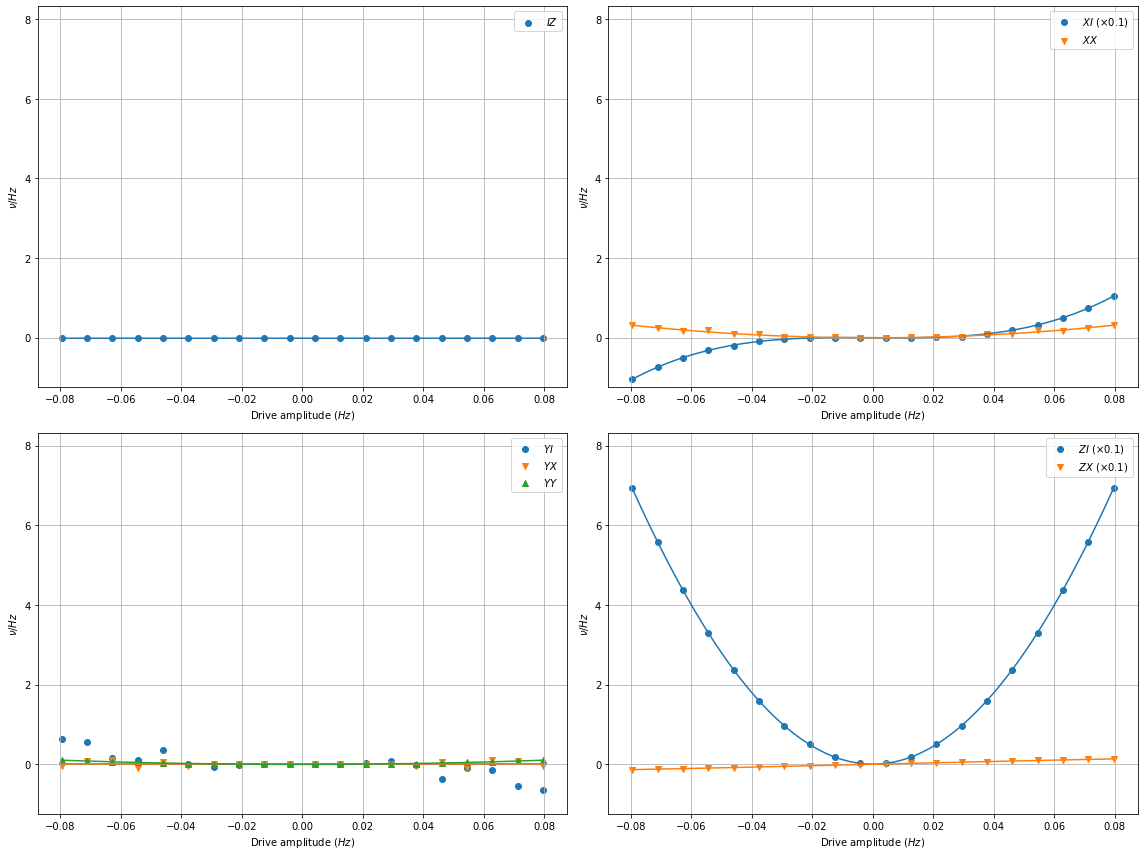

In [27]:
fig, coefficients, amp_scale, compo_scale = qudit_sim.heff.plot_amplitude_scan(amplitudes, components_list, amp_scale=FrequencyScale.Hz)

In [28]:
qudit_sim.heff.print_amplitude_scan(coefficients, amp_scale, compo_scale)

LaTeXRepr("\begin{align}\frac{\nu_{IZ}}{\mathrm{Hz}} &=-\left(1.44 \times 10^{-2}\right)+ 0.189 A^2-9.67 A^4 \\ \frac{\nu_{XI}}{\mathrm{Hz}} &=-5.21 A+ \left(2.15 \times 10^{4}\right) A^3 \\ \frac{\nu_{XX}}{\mathrm{Hz}} &=-\left(3.01 \times 10^{-3}\right)+ 49.4 A^2+ 80.3 A^4 \\ \frac{\nu_{YI}}{\mathrm{Hz}} &=-\left(6.21 \times 10^{-9}\right)+ \left(1.25 \times 10^{-4}\right) A^2-\left(1.86 \times 10^{-2}\right) A^4 \\ \frac{\nu_{YX}}{\mathrm{Hz}} &=\left(5.08 \times 10^{-7}\right) A-\left(2.06 \times 10^{-4}\right) A^3 \\ \frac{\nu_{YY}}{\mathrm{Hz}} &=-\left(2.97 \times 10^{-3}\right)+ 16.2 A^2+ 78.5 A^4 \\ \frac{\nu_{ZI}}{\mathrm{Hz}} &=\left(1.84 \times 10^{-2}\right)+ \left(1.13 \times 10^{4}\right) A^2-\left(5.74 \times 10^{4}\right) A^4 \\ \frac{\nu_{ZX}}{\mathrm{Hz}} &=18.0 A-\left(1.83 \times 10^{2}\right) A^3\end{align} A: amplitude in $\mathrm{Hz}$")